## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.

In [1]:
!pip install -U -q tensorflow tensorflow_datasets
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

'apt' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow import keras
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [6]:
MODEL_NAME_DEPLOY= './models/production/resnet_model_74.h5'
converted_model_dir= './models/production/resnet_model_74.tflite'
model = keras.models.load_model(MODEL_NAME_DEPLOY)

In [9]:
#Convert Model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = (tf.lite.Optimize.OPTIMIZE_FOR_SIZE)
tflite_quant_model = converter.convert()
open(converted_model_dir, "wb")

INFO:tensorflow:Assets written to: C:\Users\dylan\AppData\Local\Temp\tmp2m7a49iq\assets


INFO:tensorflow:Assets written to: C:\Users\dylan\AppData\Local\Temp\tmp2m7a49iq\assets


<_io.BufferedWriter name='./models/production/resnet_model_74.tflite'>

In [98]:
model.save('./models/' + MODEL_NAME + '.h5')

In [100]:
model.evaluate(test_spectrogram_ds, return_dict=True)

11/11 [==============================] - 3s 200ms/step - loss: 1.9286 - accuracy: 0.3538


{'loss': 1.9285887479782104, 'accuracy': 0.3537802994251251}

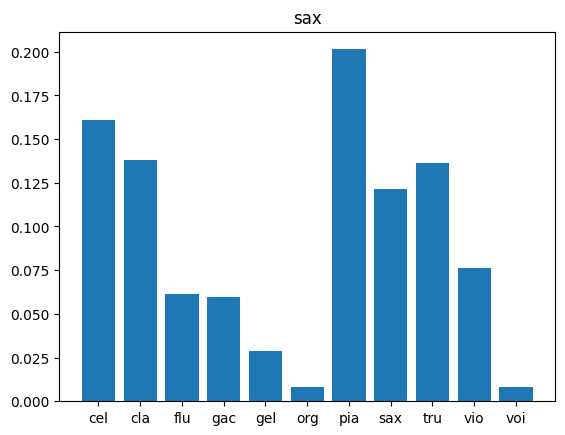

tf.Tensor(
[[ 0.74290884  0.5888645  -0.22324288 -0.2488285  -0.9708343  -2.2585208
   0.9682631   0.4626998   0.5777373  -0.00263867 -2.2074778 ]], shape=(1, 11), dtype=float32)


In [111]:
x = data_dir/'sax/[sax][cla]1602__3.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(tf.reduce_mean(x, axis=-1, keepdims=True), axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['cel', 'cla', 'flu', 'gac', 'gel', 'org', 'pia', 'sax', 'tru', 'vio', 'voi']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('sax')
plt.show()

display.display(display.Audio(waveform, rate=16000))
print(prediction)

In [107]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]
    
    x = get_spectrogram(x)  
    result = self.model(x, training=False)
    
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [108]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'sax/[sax][cla]1573__1.wav')))

{'predictions': <tf.Tensor: shape=(1, 11), dtype=float32, numpy=
 array([[ 0.77701503,  0.89950556, -0.8618534 , -0.69050825, -1.0041991 ,
         -3.106368  ,  0.6814116 ,  1.1002704 ,  1.4775205 ,  0.21599972,
         -2.3469644 ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([8], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'tru'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [109]:
tf.saved_model.save(export, './models/' + MODEL_NAME)
imported = tf.saved_model.load('./models/' + MODEL_NAME)
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: ./models/CNN_Audio_Classifyer_Testing_Model\assets


INFO:tensorflow:Assets written to: ./models/CNN_Audio_Classifyer_Testing_Model\assets


{'predictions': <tf.Tensor: shape=(1, 11), dtype=float32, numpy=
 array([[ 0.74290884,  0.5888645 , -0.22324288, -0.2488285 , -0.9708343 ,
         -2.2585208 ,  0.9682631 ,  0.4626998 ,  0.5777373 , -0.00263867,
         -2.2074778 ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([6], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'pia'], dtype=object)>}